# Team information
|S. No|Name|email|
|-|-|-|
|1|Mathews Roy|psymr3@nottingham.ac.uk|
|2|Ewan Ross|psyer1@nottingham.ac.uk|
|3|Soham Talukdar|ppxst3@nottingham.ac.uk|
|4|Srushanth Baride|ppxsb5@nottingham.ac.uk|

# Data processing & plot libraries

In [0]:
import time
import numpy as np
import pandas as pd
from sklearn import metrics
from tabulate import tabulate
from datetime import timedelta
import matplotlib.pyplot as plt

# pyspark ML libraries

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import UnivariateFeatureSelector
from pyspark.ml.feature import ChiSqSelector, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier as pyspark_DecisionTreeClassifier

# sklearn ML libraries

In [0]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.tree import DecisionTreeClassifier as sklearn_DecisionTreeClassifier

In [0]:
# Creating a new spark session
spark = SparkSession.builder.master("local[*]").appName("MLlib lab").getOrCreate()

In [0]:
# Path to the Leukemia csv file
_leukemia_dataset_file = "/mnt/the-data-transformers/Leukemia_GSE9476.csv"

In [0]:
'''
Read data from Leukemia csv file
Max columns are set to 22285
Header is set to True as the csv file contains a header
'''
sparkDF = spark.read.option("maxColumns", 22285).csv(_leukemia_dataset_file, header=True)

In [0]:
# Converting spark DataFrame to pandas DataFrame for easy processing
pandasDF = sparkDF.toPandas()
pandasDF.head()

Out[7]:

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,1438_at,1487_at,1494_f_at,1598_g_at,160020_at,1729_at,1773_at,177_at,179_at,1861_at,200000_s_at,200001_at,200002_at,200003_s_at,200004_at,200005_at,200006_at,200007_at,200008_s_at,200009_at,200010_at,200011_s_at,200012_x_at,200013_at,200014_s_at,200015_s_at,200016_x_at,200017_at,...,AFFX-LysX-M_at,AFFX-M27830_3_at,AFFX-M27830_5_at,AFFX-M27830_M_at,AFFX-PheX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-r2-Bs-dap-3_at,AFFX-r2-Bs-dap-5_at,AFFX-r2-Bs-dap-M_at,AFFX-r2-Bs-lys-3_at,AFFX-r2-Bs-lys-5_at,AFFX-r2-Bs-lys-M_at,AFFX-r2-Bs-phe-3_at,AFFX-r2-Bs-phe-5_at,AFFX-r2-Bs-phe-M_at,AFFX-r2-Bs-thr-3_s_at,AFFX-r2-Bs-thr-5_s_at,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-Hs18SrRNA-3_s_at,AFFX-r2-Hs18SrRNA-5_at,AFFX-r2-Hs18SrRNA-M_x_at,AFFX-r2-Hs28SrRNA-3_at,AFFX-r2-Hs28SrRNA-5_at,AFFX-r2-Hs28SrRNA-M_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,1,Bone_Marrow_CD34,7.74524500119505,7.81121007534134,6.47791635228852,8.84150572057594,4.5469405821895,7.95771415034381,5.34499901190722,4.67336385511613,4.66492407696435,4.0696243853938,7.07428341012836,7.43807285615198,6.82183168083122,8.36021094261399,7.58774421042457,7.23850067108989,5.73440122891825,5.86572093709168,9.29510364279376,6.63699583167985,9.75554096112187,10.2125037592264,12.4072510631567,12.9772829451237,10.9494104971535,10.6114859992921,11.3820531662505,11.3428916400888,10.3024054117681,11.28586083841,12.5233250319206,9.14086773983838,12.8443282271805,12.5966271258493,10.3265400494895,9.21371508610917,12.6044684133243,12.3732711676939,...,4.56810259616506,7.61953363806961,8.34338888891647,9.7325175304411,6.09929797188769,4.00051144053717,3.78706799496998,3.62947372237495,3.91346154545267,3.82770159268882,4.02977682303784,3.76819617607289,4.09208790442887,4.3890216416854,3.89877941641535,4.09723211007773,4.51770015184237,5.36489656987136,4.28055238311876,7.46681436568113,7.07133516607174,7.80009077238972,8.66845438091539,8.68213083954868,10.7064933156398,10.8338650824032,7.72691937010064,7.78971294759834,6.32169978256436,9.61423038707479,5.05884906355157,6.81000356185228,12.8000601994153,12.7186115474035,5.39151157002182,4.66616566659989,3.97475949012144,3.65669311996003,4.16062155445183,4.13924884553532
1,12,Bone_Marrow_CD34,8.08725200850986,7.24067331083678,8.58464840530855,8.9835712260236,4.54893416449282,8.01165205655946,5.57964654533655,4.82818367944698,5.17183525709646,4.29987530696569,7.142593637847,7.52439087254722,7.13038907536095,8.41571429416201,7.58387260965911,7.31387005928921,5.97608435809263,6.16470994790605,9.446879444909,6.59987212106388,9.42375402925316,10.010800545985,12.4112763737065,12.7584342618747,10.4515031583186,10.1768351079433,10.6661052363202,10.7482831854979,9.70525247873508,10.8609362415014,11.9002552907414,8.87945392257804,12.775879673495,12.3702245325833,9.62232802727872,8.92203663914082,12.3001249211742,11.9834172623061,...,4.63979155692597,7.43993608320862,7.43925373897001,9.42579421129795,6.10773008838127,4.12010603519148,3.83482621636727,3.79332299583567,3.8056081256028,3.71303638021025,4.63218716052627,3.74274573383988,4.19386422436012,4.73000410653151,3.82446524836006,4.01356134285356,4.58505780521766,5.2825917469801,4.29560470836821,7.12181903219694,6.79467969148148,7.54675447918691,8.61932295025616,8.77950473589525,10.0786165644472,10.064735211129,6.97836035256138,6.60425566516114,5.53143171927693,8.04843784954171,4.43615259371806,6.75147094561877,12.4727057814784,12.3335932023584,5.37973825546594,4.65678572080881,4.18834812377709,3.79253460224534,4.2044138400184,4.12269983763514
2,13,Bone_Marrow_CD34,7.79205557755844,7.54936775520293,11.053504051356,8.90970256236097,4.54932764667886,8.23709920681109,5.40648931670832,4.61557197116

In [0]:
y = sparkDF.select('type')
X = sparkDF.drop('type')

In [0]:
X_rows = np.array(X.collect()).astype(float)
y_rows = np.array(y.collect()).astype(str)

In [0]:
X_rows = preprocessing.scale(np.array(X_rows, dtype=object))

In [0]:
'''
Function: isNaN
INPUT:
------
num: any type

OUTPUT:
-------
1. boolean value (true if null)
'''

def isNaN(num):
    return num != num

In [0]:
valid_X = []
valid_y = []

rowID = 0

for instance in X_rows:
  valid = True
  rowID += 1
  
  # remove all null values
  for value in instance:
    if isNaN(value):
      valid = False
      print(f"row {rowID} is invalid")
      break

  if valid:
    valid_X.append(instance)
    valid_y.append(y_rows[rowID-1])

In [0]:
preprocessed_X = pd.DataFrame(valid_X)
preprocessed_y = pd.DataFrame(valid_y)
preprocessed_X['output'] = preprocessed_y

[Code reference](https://medium.com/analytics-vidhya/removing-outliers-understanding-how-and-what-behind-the-magic-18a78ab480ff)

In [0]:
'''
Function: check_outliers_std
INPUT:
------
dataframe: spark dataframe
col_name. column name 

OUTPUT:
-------
1. boolean value, true if outliers exist
'''

def check_outliers_std(dataframe, col_name):
    lower_boundary, upper_boundary = determine_outlier_thresholds_std(dataframe, col_name)
    if dataframe[(dataframe[col_name] > upper_boundary) | (dataframe[col_name] < lower_boundary)].any(axis=None):
        return True
    else: 
        return False

In [0]:
'''
Function: determine_outlier_thresholds_std
INPUT:
------
dataframe: spark dataframe
col_name: column name

OUTPUT:
-------
1. lower and upper bound (float values)
'''

def determine_outlier_thresholds_std(dataframe, col_name):
    upper_boundary = dataframe[col_name].mean() + 2 * dataframe[col_name].std()
    lower_boundary = dataframe[col_name].mean() - 2 * dataframe[col_name].std()
    return lower_boundary, upper_boundary

In [0]:
'''
Function: replace_with_thresholds_std
INPUT:
------
dataframe: spark dataframe
cols: columns
replace: boolean flag (replace values if true)

OUTPUT:
-------
1. no return values; replace outliers with lower/upper limit values
'''

def replace_with_thresholds_std(dataframe, cols, replace=False):
    total = 0
    data = []
    
    # loop through all columns
    for col_name in cols:
          
        # ignore output column
        if col_name != 'output':
            outliers_ = check_outliers_std(dataframe, col_name)
            count = None
            
            # get lower/upper limit from method
            lower_limit, upper_limit = determine_outlier_thresholds_std(dataframe, col_name)
            
            if outliers_:
                count = dataframe[(dataframe[col_name] > upper_limit) | (dataframe[col_name] < lower_limit)][col_name].count()
                
                if replace:
                    if lower_limit < 0:
                        # We don't want to replace with negative values.
                        dataframe.loc[(dataframe[col_name] > upper_limit), col_name] = upper_limit
                    else:
                        dataframe.loc[(dataframe[col_name] < lower_limit), col_name] = lower_limit
                        dataframe.loc[(dataframe[col_name] > upper_limit), col_name] = upper_limit
                        
            outliers_status = check_outliers_std(dataframe, col_name)
            data.append([outliers_, outliers_status,count, col_name, lower_limit, upper_limit])
            
            if count:
              total = total + count
            
    print(f"Replaced (Total): {total}")
            
    table = tabulate(data, headers=['Outlier (Previously)', 'Outliers', 'Count', 'Column', 'Lower Limit', 'Upper Limit'], tablefmt='rst', numalign='right')
    print("Removing Outliers using 2 Standard Deviation")

In [0]:
_columns = list(pandasDF.columns)
_columns.remove("type")
_columns.append("type")

In [0]:
# turn it into a dataframe
preprocessed_X = pd.DataFrame(preprocessed_X)
preprocessed_X.set_axis(_columns, axis=1, inplace=True)

In [0]:
# Converting string categorical to numerical
LE = LabelEncoder()
preprocessed_X['type'] = LE.fit_transform(preprocessed_X['type'])
preprocessed_X['type'] = preprocessed_X['type'].astype('int32')

In [0]:
replace_with_thresholds_std(preprocessed_X, preprocessed_X.columns, True)

Replaced (Total): 65026
Removing Outliers using 2 Standard Deviation

In [0]:
pandasDF = preprocessed_X 

[Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)

In [0]:
# Getting the DataFrame shape
# The data is suffering the 'curse of dimensionality' as the no.of features are exponentially greater than the no.of samples
pandasDF.shape

Out[23]: (64, 22285)

In [0]:
bone_marrow_type = pandasDF["type"].unique()

In [0]:
# Converting pandas DataFrame to spark DataFrame
sparkDF = spark.createDataFrame(pandasDF)

# Converting spark DataFrame columns to float
sparkDF = sparkDF.select(*(F.col(c).cast("float").alias(c) for c in sparkDF.columns))

In [0]:
sparkDF.write.parquet("/mnt/the-data-transformers/spark_output/test_pqt")

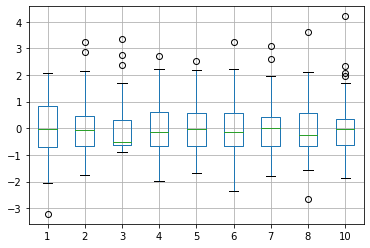

In [0]:
oldDF = pd.DataFrame(valid_X)
oldBoxplot = oldDF.boxplot(column=[1,2,3,4,5,6,7,8,10])  

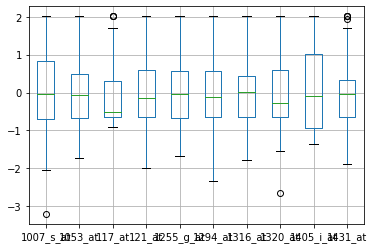

In [0]:
newDF = preprocessed_X
newBoxplot = newDF.boxplot(
  column=[
    newDF.columns[1], 
    newDF.columns[2], 
    newDF.columns[3],
    newDF.columns[4],
    newDF.columns[5], 
    newDF.columns[6], 
    newDF.columns[7],
    newDF.columns[8],
    newDF.columns[9],
    newDF.columns[10],
  ])